In [6]:
# Check the corresponding folder.
!ls


drive  project	sample_data


In [7]:
# Change the working directory of the notebook
%cd /content/project
!pwd

/content/project
/content/project


In [8]:
# Ejecution
!python main_pipeline.py

Model Evaluation:

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1394
           1       0.81      0.87      0.84       606

    accuracy                           0.90      2000
   macro avg       0.87      0.89      0.88      2000
weighted avg       0.90      0.90      0.90      2000

Model saved at /content/project/decision_tree_model.joblib


In [9]:
# This tells python to look for the modulo

import sys
sys.path.append("/content/project")


In [10]:
# Import the modules
from data_generation import generate_synthetic_data
from feature_engineering import add_kurtosis_features
from anomaly_detection import DecisionTreeAnomalyDetector


In [11]:
# generate synthetic data
df = generate_synthetic_data(
    n_samples=5000,
    n_features=10
)

df.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,-0.610582,-2.623033,-1.690824,0.832712,1.813135,1.118949,-1.247725,0.136994,-2.685528,-2.929643,0
1,0.652743,3.289310,-0.827060,1.357594,4.041987,3.794888,1.001925,4.830743,-0.724700,1.864780,0
2,1.943888,-0.244799,-2.683838,2.987061,0.747373,-0.364708,-0.394231,-0.769939,-0.686706,2.471947,1
3,-0.452503,0.855161,0.530575,-0.748409,-1.231524,-2.832018,-1.311830,-0.175025,-0.901862,0.292952,0
4,0.307364,1.041353,-2.711307,2.190417,-1.705027,-3.738438,-1.588384,0.271206,-2.011911,3.042341,0


In [12]:
# Feature Engineering (Kurtosis)

df_fe = add_kurtosis_features(df)

df_fe.filter(like="kurtosis").head()


,feature_0_kurtosis,feature_1_kurtosis,feature_2_kurtosis,feature_3_kurtosis,feature_4_kurtosis,feature_5_kurtosis,feature_6_kurtosis,feature_7_kurtosis,feature_8_kurtosis,feature_9_kurtosis
0,0.065213,-0.188978,-0.142903,-0.129667,0.016815,0.083083,-0.157494,-0.162593,0.178705,-0.279441
1,0.065213,-0.188978,-0.142903,-0.129667,0.016815,0.083083,-0.157494,-0.162593,0.178705,-0.279441
2,0.065213,-0.188978,-0.142903,-0.129667,0.016815,0.083083,-0.157494,-0.162593,0.178705,-0.279441
3,0.065213,-0.188978,-0.142903,-0.129667,0.016815,0.083083,-0.157494,-0.162593,0.178705,-0.279441
4,0.065213,-0.188978,-0.142903,-0.129667,0.016815,0.083083,-0.157494,-0.162593,0.178705,-0.279441


In [13]:
# Sepatate characteristics and objective

X = df_fe.drop(columns=["target"])
y = df_fe["target"]


In [14]:
# Train / Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [25]:
# Training the decision tree
detector = DecisionTreeAnomalyDetector(random_state=42)
detector.train(X_train, y_train)


In [16]:
# Evaluate the model
report = detector.evaluate(X_test, y_test)
print(report)


              precision    recall  f1-score   support

           0       0.94      0.84      0.89       698
           1       0.70      0.87      0.78       302

    accuracy                           0.85      1000
   macro avg       0.82      0.86      0.83      1000
weighted avg       0.87      0.85      0.85      1000



In [26]:
#Save the trained model
detector.save("/content/project/decision_tree_model.joblib")


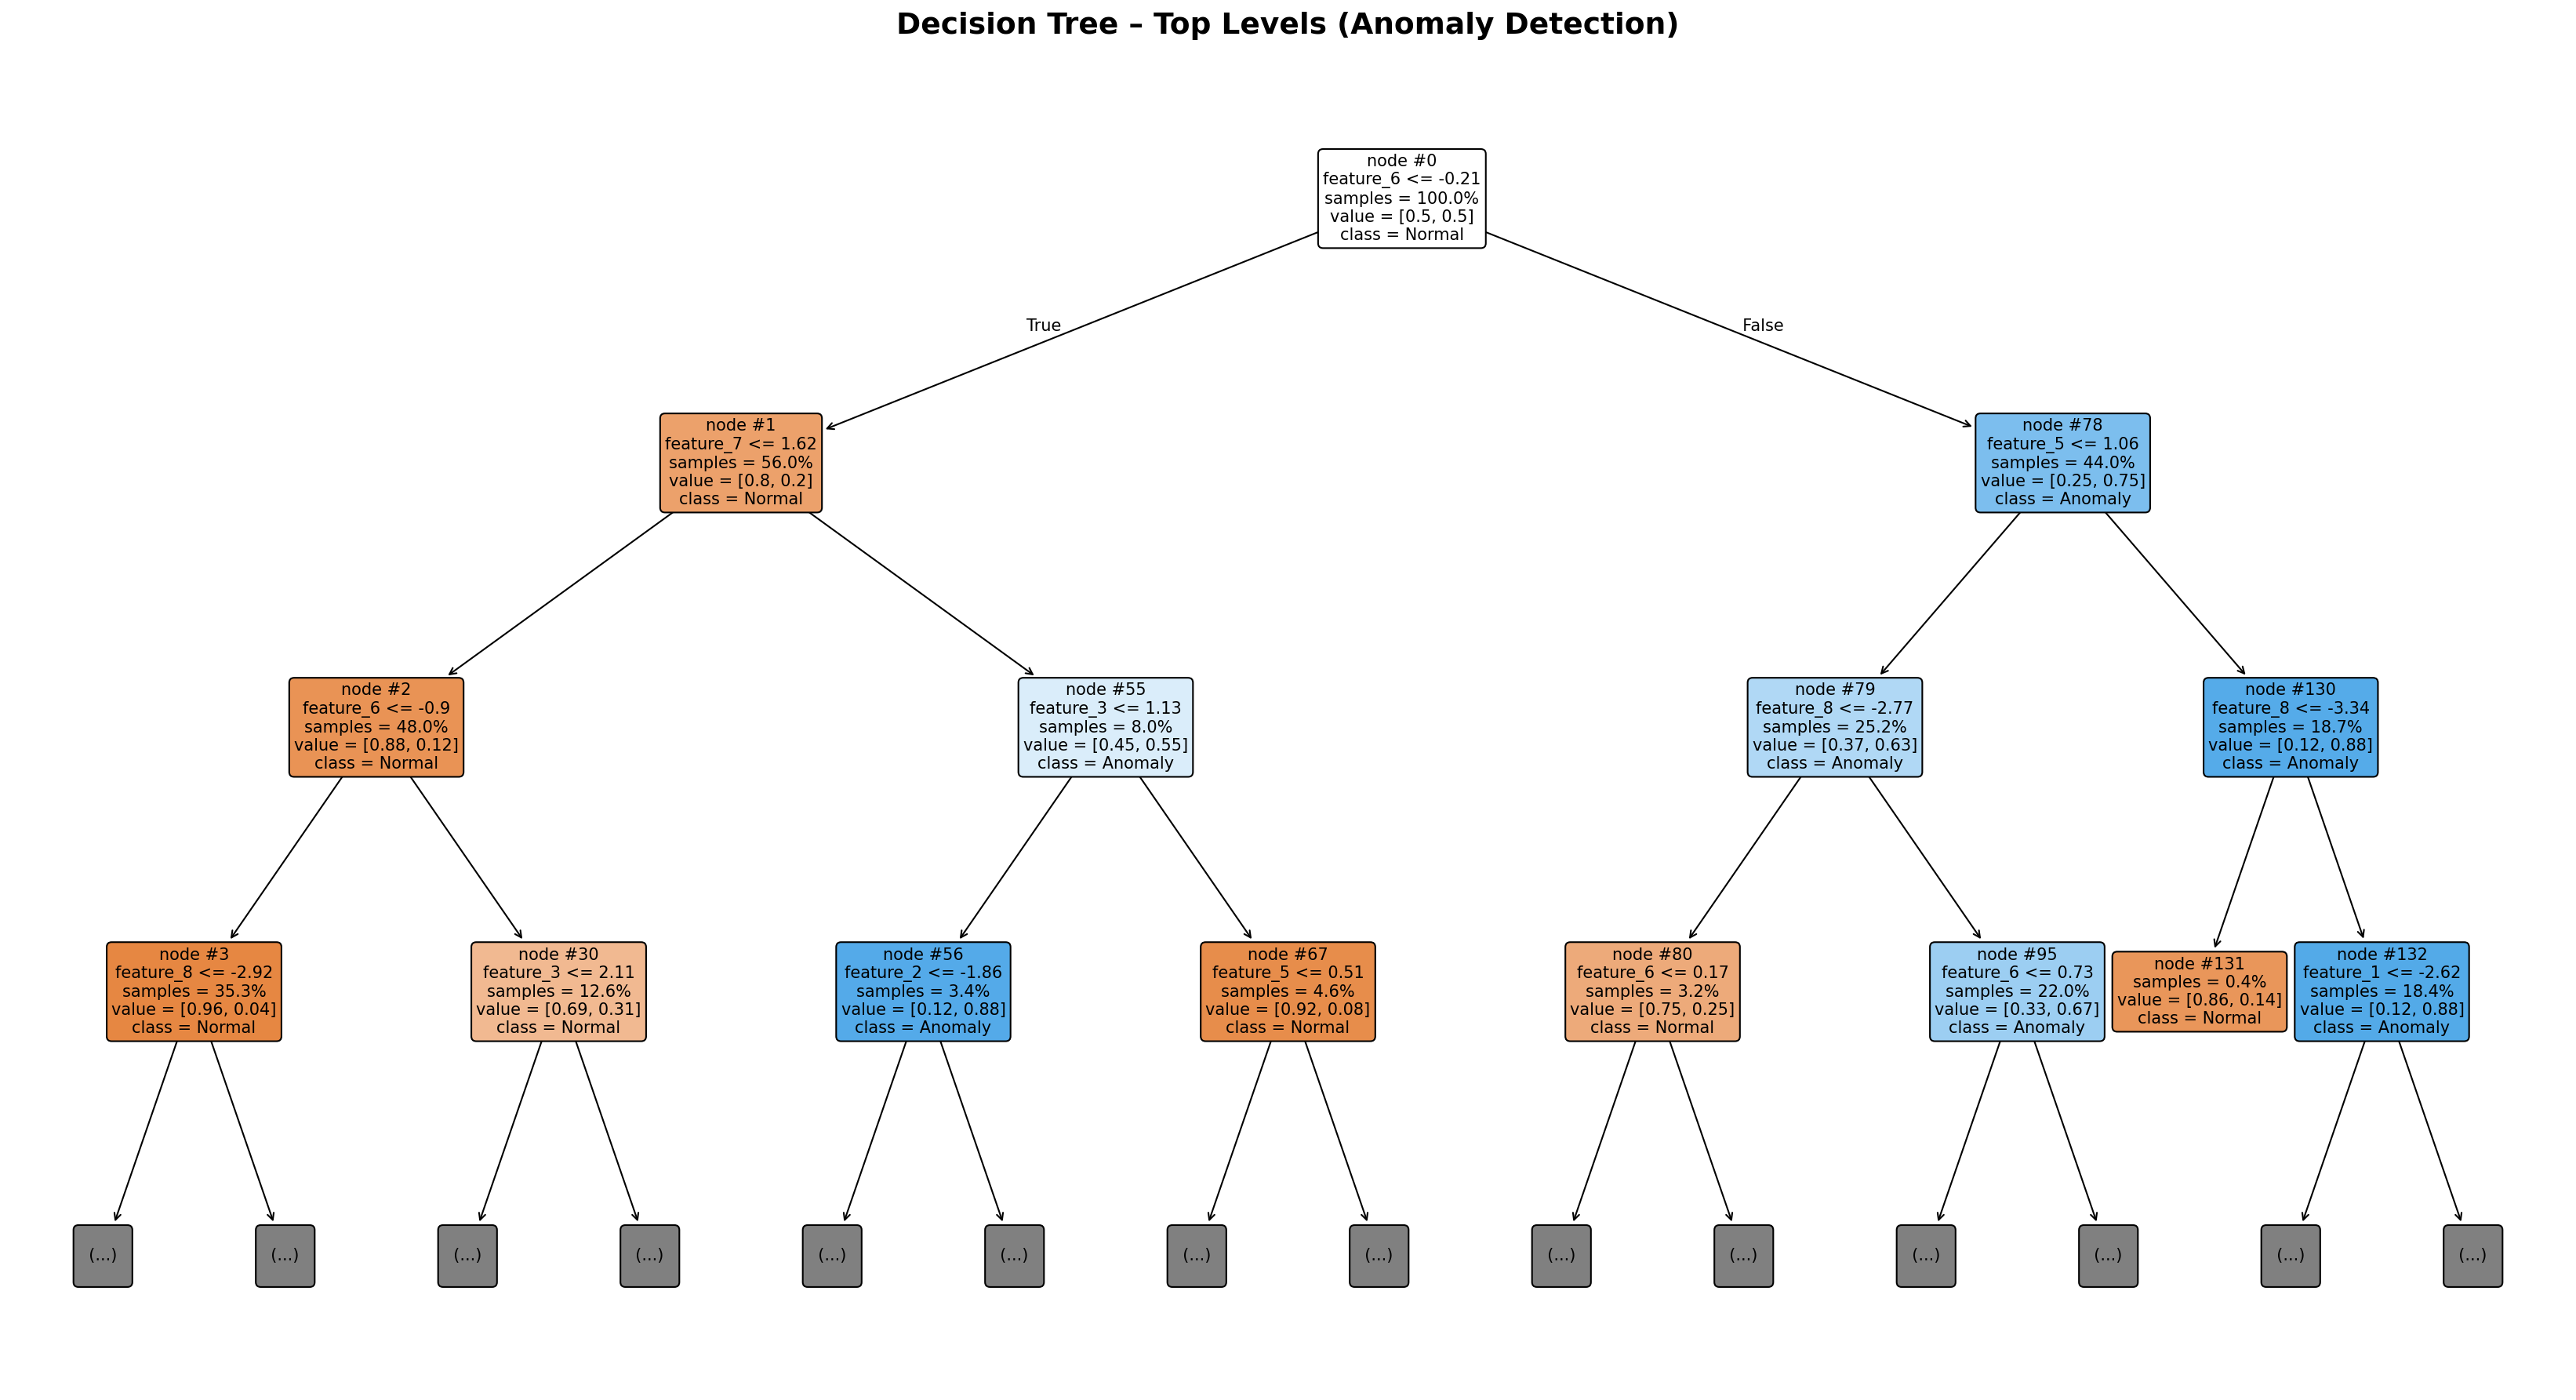

In [27]:
# Decision Tree Visualisation
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 12), dpi=150)

plot_tree(
    detector.model,
    feature_names=X_train.columns,
    class_names=["Normal", "Anomaly"],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10,
    proportion=True,
    impurity=False,
    precision=2,
    node_ids=True
)

plt.title(
    "Decision Tree – Top Levels (Anomaly Detection)",
    fontsize=18,
    fontweight="bold",
    pad=20
)

plt.tight_layout()
plt.show()


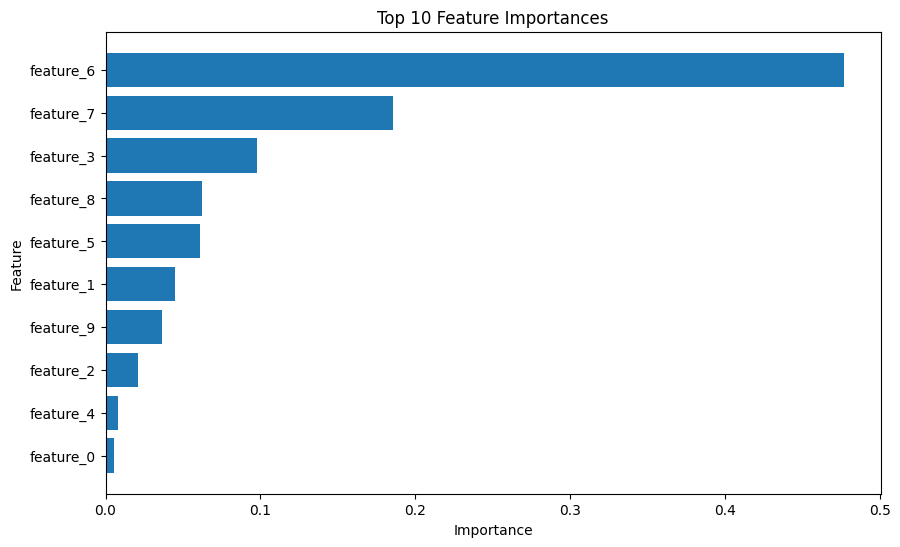

In [28]:
# Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

importances = detector.model.feature_importances_

feature_importance_df = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df["feature"][:10][::-1],
    feature_importance_df["importance"][:10][::-1]
)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


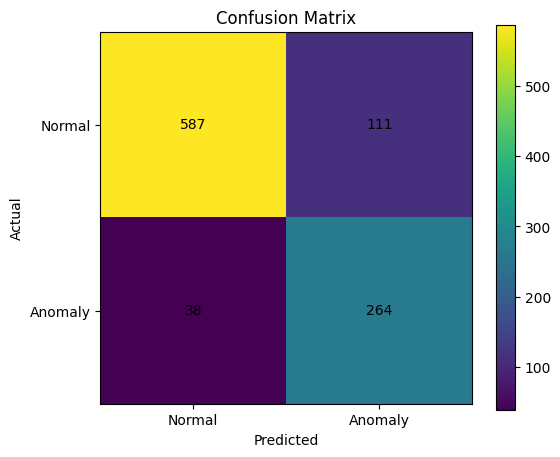

In [29]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = detector.model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.yticks([0, 1], ["Normal", "Anomaly"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [31]:
from google.colab import files
import shutil

shutil.make_archive(
    "/content/project",
    "zip",
    "/content/project"
)

files.download("/content/project.zip")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>